# ViT fine tuning with medical image dataset

This demo is going to use the SPMS vs RRMS npy dataset to fine tuning. 


In [1]:
from tqdm import tqdm 
import random

import numpy as np  
import torch   
import torch.nn as nn  
from transformers import ViTModel, ViTConfig  
from torchvision.transforms import v2
import torchvision
from torch.optim import Adam, lr_scheduler 
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics
import imblearn
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
# DEVICE = torch.device("cpu")

# RRMS Worsening Stable
train_img_path = "data/preprocessed_data/SPMS_3Classes_187patients/training_img.npy"
train_lbl_path = "data/preprocessed_data/SPMS_3Classes_187patients/training_lbl.npy"
test_img_path = "data/preprocessed_data/SPMS_3Classes_187patients/testing_img.npy"
test_lbl_path = "data/preprocessed_data/SPMS_3Classes_187patients/testing_lbl.npy"
val_img_path = "data/preprocessed_data/SPMS_3Classes_187patients/validation_img.npy"
val_lbl_path = "data/preprocessed_data/SPMS_3Classes_187patients/validation_lbl.npy"

# # SPMS vs RRMS
# train_img_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_img_train.npy"
# train_lbl_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_lbl_train.npy"
# test_img_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_img_test.npy"
# test_lbl_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_lbl_test.npy"
# val_img_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_img_test.npy"
# val_lbl_path = "data/preprocessed_data/SPMS_RRMS_CONTROL/SPMSvsRRMS_lbl_test.npy"


In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
setup_seed(34)

In [3]:
# Define the Torch Dataset 
from numpy import dtype


class MedicalImageDataset(Dataset):
    def __init__(self, img_path, lbl_path, transform = None, distribution = None):
        # read the npy file get all the data
        self.images = np.load(img_path).astype("float16")
        self.length = self.images.shape[0]
        self.height = self.images.shape[2]
        self.width = self.images.shape[3]
        self.images = self.images.reshape((self.length, 3, 256,256))
        self.labels = np.load(lbl_path).flatten().astype("int")
        
    #  (has to be overwrote) define a iterator how to get the image and label by giving index
    def __getitem__(self,i):
        # std, mean = self.get_std_mean(self.images[i])
        transforms = v2.Compose([

            # resize is required for EfficientNet

            # resize is required for vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1')
            # v2.Resize((384,384), antialias=True),
            
            v2.CenterCrop((224,224)),


            v2.RandomChoice([
                v2.RandomVerticalFlip(p=0.2),
                v2.RandomHorizontalFlip(p=0.2),
                v2.ColorJitter(contrast=(0.8,1.2)),
                v2.ColorJitter(brightness=(0.9,1.1))
            ])
            # augmentation added


            # v2.Normalize(mean=mean, std=std),
        ])
        img = transforms(torch.from_numpy(self.images[i].astype(np.float32)))
        return img, self.labels[i]
    
    # (has to be overwrote) return the total number of samples from the dataset
    def __len__(self):
        return self.labels.shape[0]

    def get_std_mean(self, array):
        std, mean = [], []
        for i in array:
            std.append(np.std(i, dtype='float64'))
            mean.append(np.mean(i, dtype='float64'))
        return std, mean


In [4]:
class Model(nn.Module):
    def __init__(self, train_dataset:Dataset, val_dataset:Dataset, test_dataset:Dataset, epoch:int, lr:float ,model_type:str, schedular:bool, bs:int, stepSize:int):
        super().__init__()
        # create all the dataloader
        self.train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
        self.validate_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
        self.model = None

        if model_type == 'effinet':
            self.model =  torchvision.models.efficientnet_v2_s(weights= 'IMAGENET1K_V1')
            self.model.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(1280, 3)
            )

        elif model_type == 'ViT':
            self.model = torchvision.models.vit_b_32(weights='DEFAULT')
            self.model.heads = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(768, 3)
            )
            # self.model = torchvision.models.vit_l_16(weights='ViT_L_16_Weights.IMAGENET1K_V1')
            # self.model.heads = nn.Sequential(
            #     nn.Dropout(p=0.2, inplace=True),
            #     nn.Linear(1024, 2)
            # )


        self.freeze_layer()
        self.model = self.model.to(DEVICE)
        self.unique_labels = np.unique(train_dataset.labels)
        self.epoch = epoch
        self.lr = lr
        self.turn_on_schedular = schedular

        #init training and testing data
        self.train_acc = []
        self.train_loss = []
        self.test_acc = []
        self.test_loss = []
        self.conf_mat = 0

        # init all the optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.schedular = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, gamma=0.1, step_size=3,verbose=True)
        # self.schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=self.optimizer, max_lr=0.1, steps_per_epoch=len(self.train_loader), epochs=self.epoch, verbose=True)

        
    def forward(self,x):
        x = self.model(x)
        return x
    
    # freeze all the layers except full connected layer
    def freeze_layer(self):
        for name, param in self.model.named_parameters():
            # fc and classifier are depends on the names that is actually in the model, resnet uses fc, densenet uses classifier 
            if 'fc' in name or 'classifier' in name or 'head' in name:
                continue
            else:
                param.requires_grad=False

    # start the train and test function
    def start(self):
        for i in range(self.epoch):
            print("epoch: "+ str(i))
            self.train()
            self.validate()
            if self.turn_on_schedular:
                self.schedular.step()
        self.print_summary()
        self.test()


    # training process 
    def train(self):
        train_acc = 0
        train_loss = 0
        self.model.train()
        total_samples = 0
        correct_samples = 0
        for index, (image, label) in enumerate(self.train_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            self.optimizer.zero_grad()
            output = self.model(image)
            loss = self.loss_func(output, label.long())

            loss.backward()
            self.optimizer.step()

            train_loss += loss.item() *len(label)
            total_samples += len(label)

            # Select the maximum value from return matrix, 1 is the to select in the column
            _, predictions = torch.max(output, 1)
            correct_samples += (predictions == label).sum()

        train_acc = correct_samples/total_samples*100.0
        train_loss = train_loss/len(self.train_loader.dataset)
        
        print(f'Training Accuracy: {train_acc:.4f}%, Training Loss: {train_loss:.8f}')
        train_acc = train_acc.cpu().item() 

        self.train_acc.append(train_acc)
        self.train_loss.append(train_loss)

    # validate process
    def validate (self):
        self.model.eval()
        total_samples=0
        correct_samples=0
        total_loss = 0
        accuracy = 0
        predlist, lblist = torch.zeros(0, dtype=torch.long, device=DEVICE),torch.zeros(0, dtype=torch.long, device=DEVICE)
        confusion_matrix = 0
        with torch.no_grad():
            for index, (image, label) in enumerate(self.validate_loader):
                image = image.to(DEVICE)
                label = label.to(DEVICE)
                output = self.model(image)
                _, predictions = torch.max(output, 1)
                correct_samples += (predictions == label).sum().item()
                total_samples += len(label)
                total_loss += self.loss_func(output, label.long()).item() * len(label)

                predlist = torch.cat([predlist, predictions.view(-1)])
                lblist = torch.cat([lblist, label.view(-1)])
            accuracy = correct_samples/total_samples*100.0
        total_loss = total_loss/len(self.test_loader.dataset) # type: ignore
        print(f'Validation Accuracy: {accuracy:.4f}%, Validation Loss: {total_loss:.8f}')
        # collecting all the testing info, if accuracy is higher than highest accuracy, then print the confusion matrix
        self.test_acc.append(accuracy)
        self.test_loss.append(total_loss)
        if (len(self.test_acc)==1 or accuracy >= max(self.test_acc)):
            confusion_matrix = sklearn.metrics.confusion_matrix(lblist.cpu().numpy(), predlist.cpu().numpy())
            self.print_confMat(confusion_matrix=confusion_matrix)

    # test process
    def test (self):
        self.model.eval()
        total_samples=0
        correct_samples=0
        total_loss = 0
        accuracy = 0
        predlist, lblist = torch.zeros(0, dtype=torch.long, device=DEVICE),torch.zeros(0, dtype=torch.long, device=DEVICE)
        confusion_matrix = 0
        with torch.no_grad():
            for index, (image, label) in enumerate(self.test_loader):
                image = image.to(DEVICE)
                label = label.to(DEVICE)
                output = self.model(image)
                _, predictions = torch.max(output, 1)
                correct_samples += (predictions == label).sum().item()
                total_samples += len(label)
                total_loss += self.loss_func(output, label.long()).item() * len(label)

                predlist = torch.cat([predlist, predictions.view(-1)])
                lblist = torch.cat([lblist, label.view(-1)])
            accuracy = correct_samples/total_samples*100.0
        total_loss = total_loss/len(self.test_loader.dataset) # type: ignore
        print(f'Testing Accuracy: {accuracy:.4f}%, Testing Loss: {total_loss:.8f}')
        # collecting all the testing info, if accuracy is higher than highest accuracy, then print the confusion matrix

        confusion_matrix = sklearn.metrics.confusion_matrix(lblist.cpu().numpy(), predlist.cpu().numpy())
        self.print_confMat(confusion_matrix=confusion_matrix)
    
    def print_confMat(self, confusion_matrix):
        # fig = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=self.unique_labels)
        fig = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0,1,2])
        fig.plot()
        plt.show()

    # helper function plot the training and testing accuracy 
    def print_summary(self ):
        x = range(self.epoch)
        plt.subplot(1,2,1)
        plt.plot(x, self.train_acc, 'r--', label='train_acc')
        plt.plot(x, self.test_acc, 'g--', label='test_acc')
        plt.title('Training and testing accuracy')
        plt.xlabel('epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(x, self.train_loss, 'r--', label='train_loss')
        plt.plot(x, self.test_loss, 'g--', label='test_loss')
        plt.title('Training and testing loss')
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    # helper function for testing single augmentation method
    def return_highest_acc(self):
        return max(self.test_acc)

# Init dataset

In [5]:
train_dataset = MedicalImageDataset(train_img_path, train_lbl_path)
val_dataset = MedicalImageDataset(val_img_path, val_lbl_path)
test_dataset = MedicalImageDataset(test_img_path, test_lbl_path)

# ViT config

In [6]:
EPOCHS = 13
LEARNING_RATE = 4e-3
BATCH_SIZE = 36

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 0
Training Accuracy: 49.1681%, Training Loss: 1.03818843
Validation Accuracy: 36.5965%, Validation Loss: 1.17893413


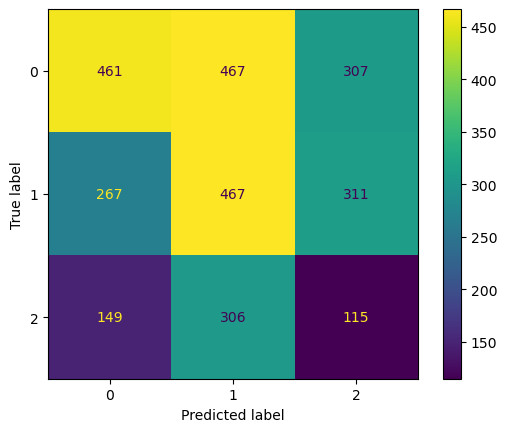

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 1
Training Accuracy: 53.8766%, Training Loss: 0.96809280
Validation Accuracy: 44.2456%, Validation Loss: 1.31302544


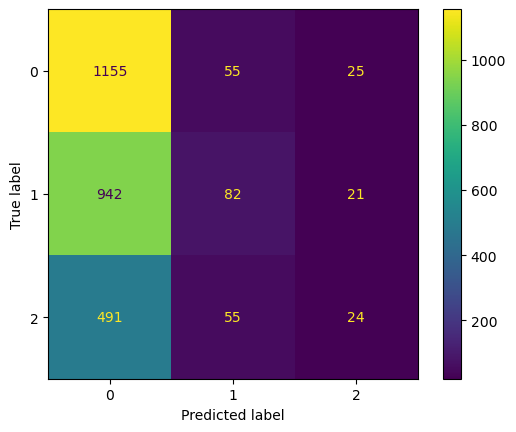

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 2
Training Accuracy: 55.9366%, Training Loss: 0.94131951
Validation Accuracy: 44.8772%, Validation Loss: 1.17221839


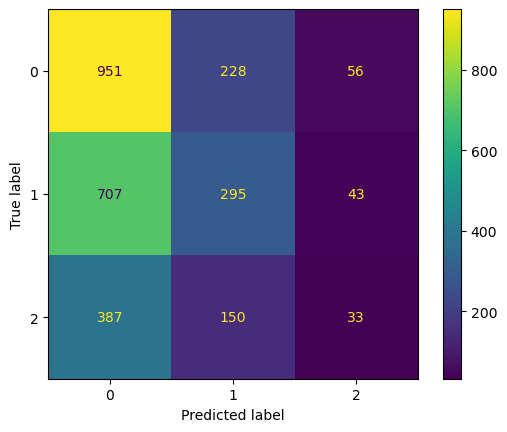

Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 3
Training Accuracy: 58.6644%, Training Loss: 0.88601543
Validation Accuracy: 43.2281%, Validation Loss: 1.10636372
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 4
Training Accuracy: 59.6491%, Training Loss: 0.87582044
Validation Accuracy: 44.4211%, Validation Loss: 1.11606811
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 5
Training Accuracy: 59.9095%, Training Loss: 0.87502443
Validation Accuracy: 43.6140%, Validation Loss: 1.11177869
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 6
Training Accuracy: 59.8189%, Training Loss: 0.86223386
Validation Accuracy: 43.5088%, Validation Loss: 1.10204052
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 7
Training Accuracy: 60.6452%, Training Loss: 0.85583626
Validation Accuracy: 43.3684%, Validation Loss: 1.10289857
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 8
Training Accuracy: 60.5320%, Training Loss: 0.86054585
Validation Accuracy: 

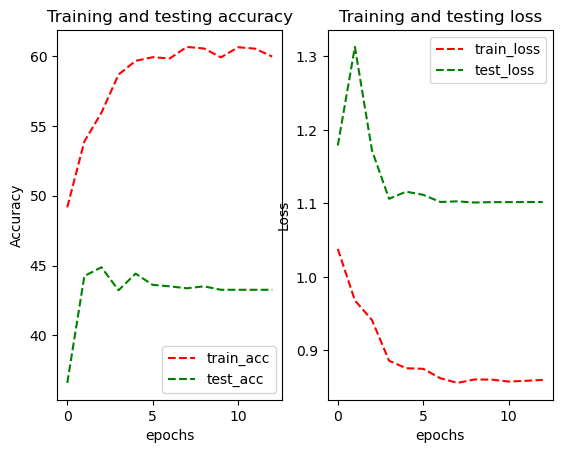

Testing Accuracy: 44.8070%, Testing Loss: 1.09684327


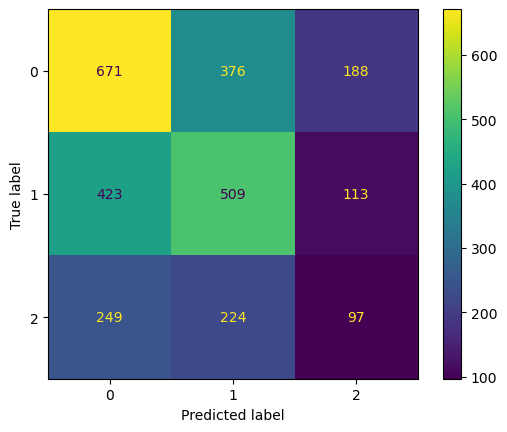

In [57]:
model = Model(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='ViT', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=7)
model.start()

# EffiNet config

In [58]:
EPOCHS = 15
LEARNING_RATE = 0.0003
BATCH_SIZE = 48

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 0
Training Accuracy: 51.2394%, Training Loss: 0.97211002
Validation Accuracy: 46.7719%, Validation Loss: 1.14097405


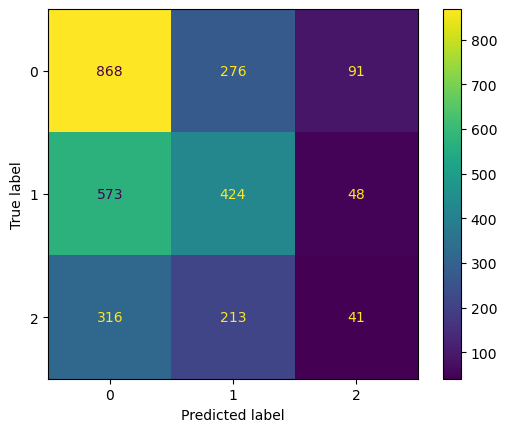

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 1
Training Accuracy: 69.5642%, Training Loss: 0.69427587
Validation Accuracy: 47.1228%, Validation Loss: 1.23862929


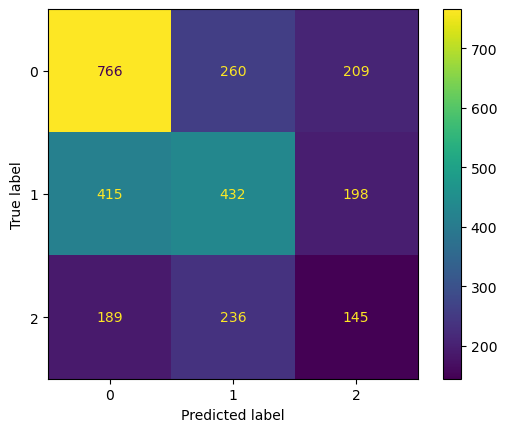

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 2
Training Accuracy: 82.1053%, Training Loss: 0.45228365
Validation Accuracy: 51.0526%, Validation Loss: 1.43883627


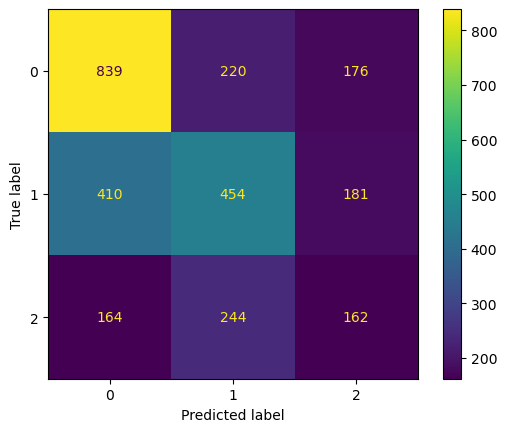

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 3
Training Accuracy: 88.0815%, Training Loss: 0.32433903
Validation Accuracy: 51.4737%, Validation Loss: 1.43670131


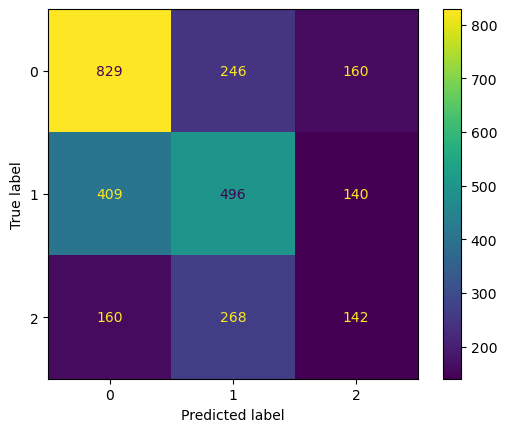

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 4
Training Accuracy: 89.1568%, Training Loss: 0.30194240
Validation Accuracy: 51.7895%, Validation Loss: 1.48408691


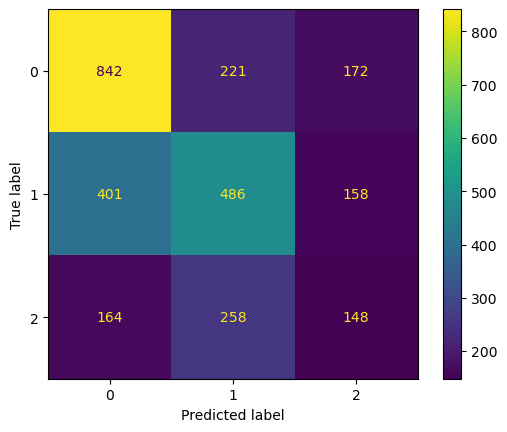

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 5
Training Accuracy: 89.6435%, Training Loss: 0.27797624
Validation Accuracy: 53.2281%, Validation Loss: 1.59369105


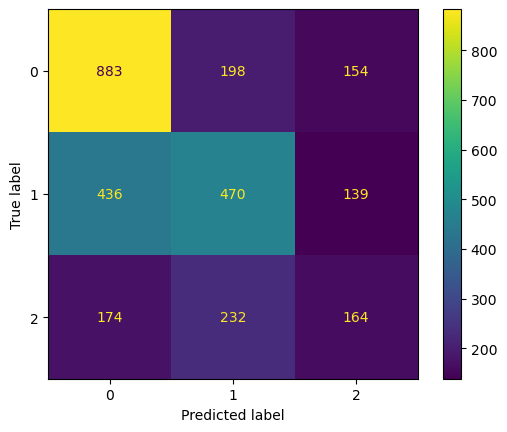

Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 6
Training Accuracy: 90.0057%, Training Loss: 0.26756733
Validation Accuracy: 52.5965%, Validation Loss: 1.54176419
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 7
Training Accuracy: 90.2207%, Training Loss: 0.25964248
Validation Accuracy: 52.2456%, Validation Loss: 1.61960661
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 8
Training Accuracy: 90.3452%, Training Loss: 0.26061994
Validation Accuracy: 52.4912%, Validation Loss: 1.53748411
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 9
Training Accuracy: 90.3679%, Training Loss: 0.26134284
Validation Accuracy: 52.7018%, Validation Loss: 1.57161917
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 10
Training Accuracy: 90.2207%, Training Loss: 0.25703827
Validation Accuracy: 52.0702%, Validation Loss: 1.60973096
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 11
Training Accuracy: 90.7867%, Training Loss: 0.25528062
Validation Accuracy

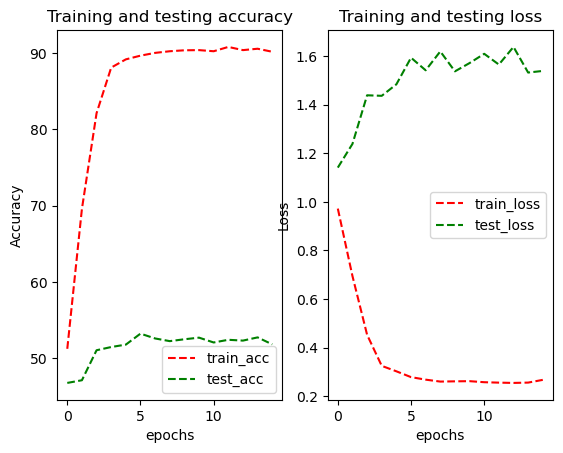

Testing Accuracy: 58.3509%, Testing Loss: 1.24300413


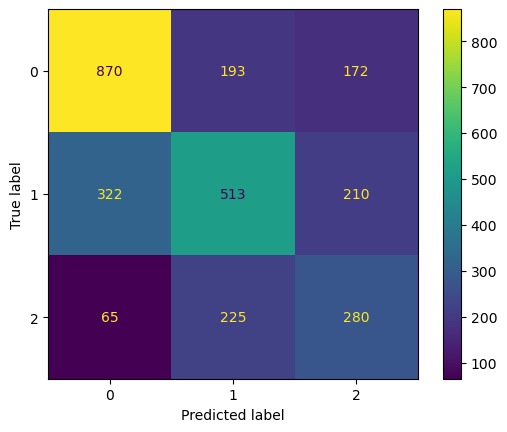

In [59]:
model = Model(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='effinet', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=3)
model.start()

# Upsampling method test

In [8]:
class Resampled_dataset(Dataset):
    def __init__(self, data, label):
        self.images = data
        self.labels = label
        unique, counts = np.unique(self.labels, return_counts=True)
        print("resampled size", self.images.shape, unique, counts)


    def __getitem__(self, index):
        transforms = v2.Compose([

            # resize is required for EfficientNet

            # resize is required for vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1')
            # v2.Resize((384,384), antialias=True),
            v2.RandomChoice([
                v2.RandomVerticalFlip(p=0.2),
                v2.RandomHorizontalFlip(p=0.2),
                v2.ColorJitter(contrast=(0.8,1.2)),
                v2.ColorJitter(brightness=(0.9,1.1))
            ]),

            v2.Resize((224,224), antialias=True),
            # v2.Normalize(mean=mean, std=std),
        ])
        img = transforms(torch.from_numpy(self.images[index].astype(np.float32)))
        return img, self.labels[index]
    
    def __len__(self):
        return self.images.shape[0]

def resampling(imgs, lbls, type='SMOTE' ):
    raw_imgs = imgs
    raw_labels = lbls

    # get all the images and labels out form the input dataset
    # for index,(img, lab) in enumerate(dataset):
    #     raw_imgs.append(img.numpy())
    #     raw_labels.append(lab)
    print(raw_imgs[0].dtype, raw_imgs[0].shape)
    height = raw_imgs[0].shape[1]
    width = raw_imgs[0].shape[2]
    channel = raw_imgs[0].shape[0]
    # change the data type from original list to numpy array
    raw_imgs = np.array(raw_imgs)
    raw_labels = np.array(raw_labels)

    # resize the image form 4D array(total num of samples, C, W, H ) to 2d array(total num of samples, C*H*W) 
    raw_imgs = np.reshape(raw_imgs, (raw_imgs.shape[0], height*width*channel))

    # Define the SMOTE alg, SMOTE can be change to other varients of SMOTE
    s = 0
    if (type == 'SMOTE'):
        print("SMOTE")
        s = imblearn.over_sampling.SMOTE(random_state=42)
    elif(type == 'board_smote'):
        print("board_smote")
        s = imblearn.over_sampling.BorderlineSMOTE(random_state=42)
    elif(type == 'ADASYNC'):
        print("ADASYNC")
        s = imblearn.over_sampling.ADASYN(random_state=42)
    elif(type == 'SVM'):
        print("SVM")
        s = imblearn.over_sampling.SVMSMOTE(random_state=42)
    elif(type == 'SMOTEENN'):
        print("SMOTEENN")
        s = imblearn.combine.SMOTEENN(random_state=42)
    elif(type == "SMOTETomek"):
        print("SMOTETomek")
        s = imblearn.combine.SMOTETomek(random_state = 42)
    resampled_img, resampled_lbl = s.fit_resample(raw_imgs, raw_labels)
    # resize the output of samples form (total num of samples, C*H*W) to (total num of samples, C, W, H )
    resampled_img = resampled_img.reshape((resampled_img.shape[0], channel,height,width))
    return Resampled_dataset(resampled_img, resampled_lbl)

## EffNet trail

float16 (3, 256, 256)
SMOTE
resampled size (11115, 3, 256, 256) [0 1 2] [3705 3705 3705]
Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 0


d:\progarmSoftware\Miniconda\envs\torch2.1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 50.3194%, Training Loss: 0.98881647
Validation Accuracy: 45.8947%, Validation Loss: 1.43331522


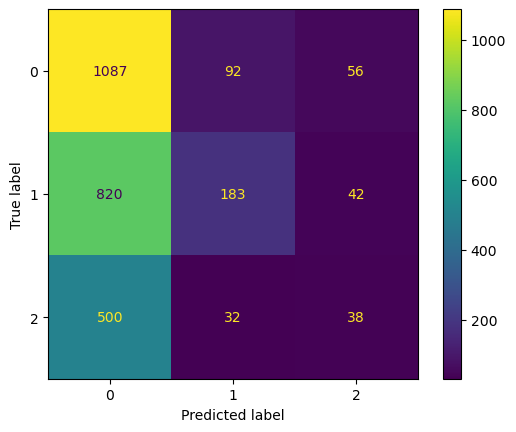

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 1


d:\progarmSoftware\Miniconda\envs\torch2.1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 69.4917%, Training Loss: 0.70036861
Validation Accuracy: 47.4035%, Validation Loss: 1.91002174


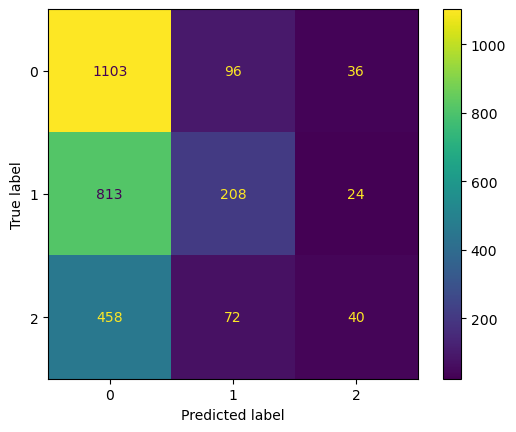

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 2


d:\progarmSoftware\Miniconda\envs\torch2.1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 79.4422%, Training Loss: 0.49381988
Validation Accuracy: 46.4912%, Validation Loss: 2.58694220
Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 3
Training Accuracy: 83.8776%, Training Loss: 0.40135055
Validation Accuracy: 48.1053%, Validation Loss: 2.07649729


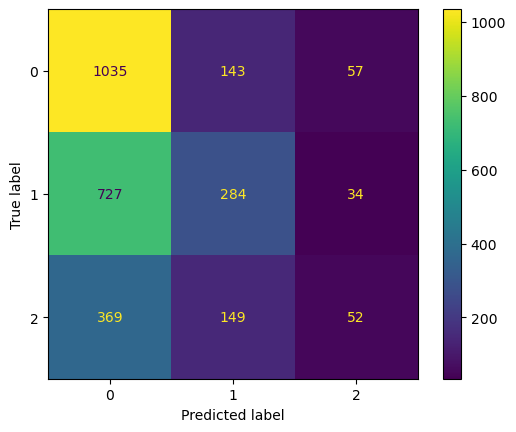

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 4


d:\progarmSoftware\Miniconda\envs\torch2.1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 85.6140%, Training Loss: 0.36725259
Validation Accuracy: 48.8070%, Validation Loss: 2.20229219


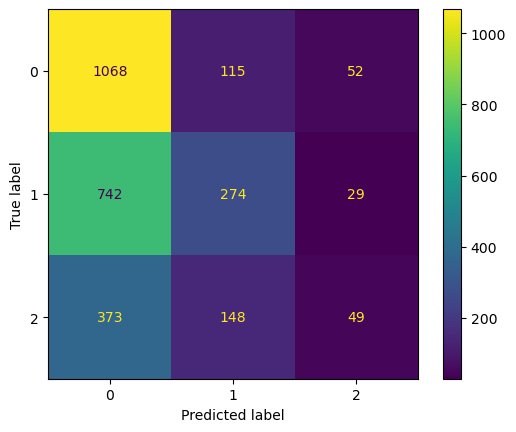

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 5


d:\progarmSoftware\Miniconda\envs\torch2.1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 86.0009%, Training Loss: 0.35767524
Validation Accuracy: 48.0702%, Validation Loss: 2.38705630
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 6
Training Accuracy: 86.4238%, Training Loss: 0.34599205
Validation Accuracy: 48.2456%, Validation Loss: 2.31146713
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 7
Training Accuracy: 86.6127%, Training Loss: 0.34289431
Validation Accuracy: 48.2807%, Validation Loss: 2.33154795
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 8
Training Accuracy: 86.4867%, Training Loss: 0.34157032
Validation Accuracy: 48.3860%, Validation Loss: 2.21495024
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 9
Training Accuracy: 86.6487%, Training Loss: 0.33825844
Validation Accuracy: 48.3158%, Validation Loss: 2.29397794
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 10
Training Accuracy: 86.9276%, Training Loss: 0.33474667
Validation Accuracy: 48.1404%, Validation Loss: 2.33139376
Adjusting learning r

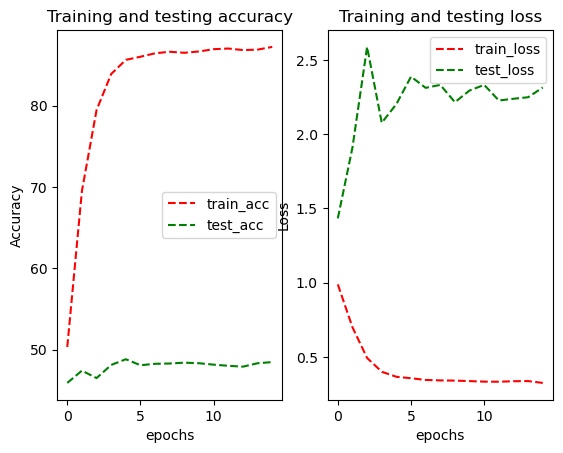

Testing Accuracy: 51.3333%, Testing Loss: 2.05726894


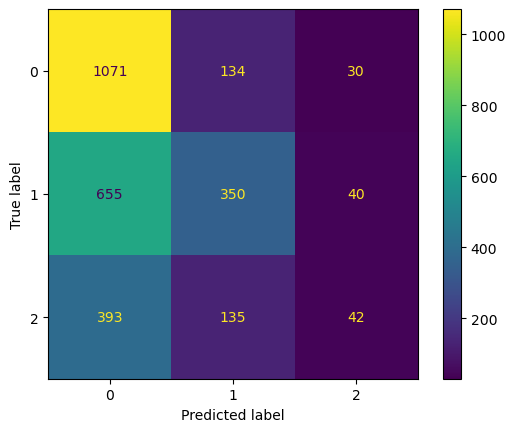

In [7]:
EPOCHS = 15
LEARNING_RATE = 0.0003
BATCH_SIZE = 48
resampled_dataset = resampling(train_dataset.images, train_dataset.labels, 'SMOTE')
model = Model(train_dataset=resampled_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='effinet', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=3)
model.start()

# ViT trail

float16 (3, 256, 256)
SMOTE
resampled size (11115, 3, 256, 256) [0 1 2] [3705 3705 3705]
Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 0
Training Accuracy: 48.5110%, Training Loss: 1.04464289
Validation Accuracy: 40.2807%, Validation Loss: 1.16207584


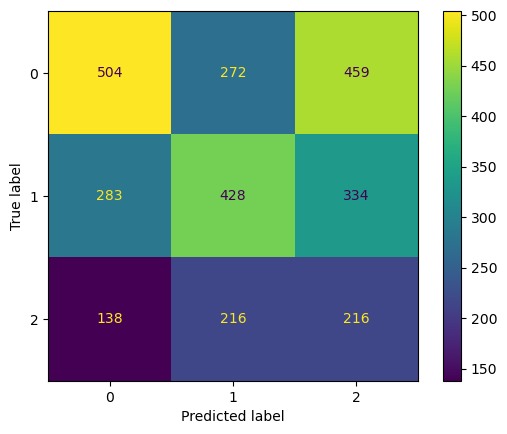

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 1
Training Accuracy: 53.6932%, Training Loss: 0.97162100
Validation Accuracy: 44.3158%, Validation Loss: 1.16332184


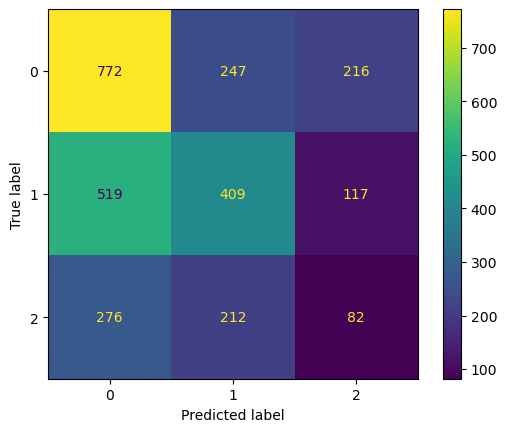

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 2
Training Accuracy: 53.9541%, Training Loss: 0.97755159
Validation Accuracy: 44.2807%, Validation Loss: 1.24160951
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 3
Training Accuracy: 57.4269%, Training Loss: 0.91046692
Validation Accuracy: 45.1930%, Validation Loss: 1.17229448


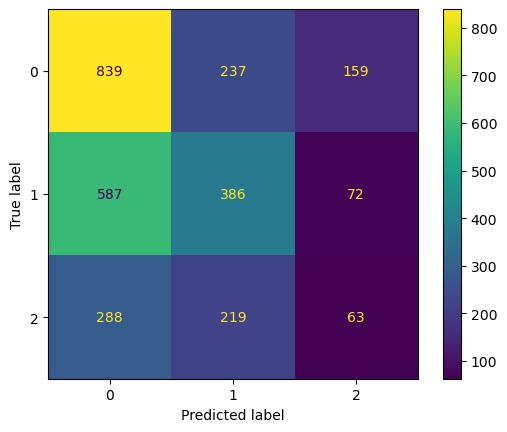

Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 4
Training Accuracy: 57.3099%, Training Loss: 0.90356745
Validation Accuracy: 43.2982%, Validation Loss: 1.15732715
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 5
Training Accuracy: 58.2546%, Training Loss: 0.89943123
Validation Accuracy: 45.8596%, Validation Loss: 1.12133666


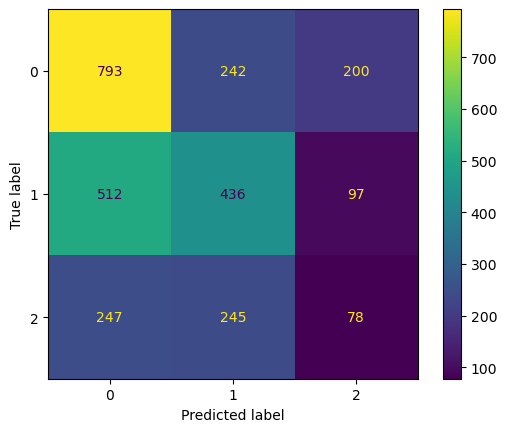

Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 6
Training Accuracy: 58.2996%, Training Loss: 0.88893021
Validation Accuracy: 45.4035%, Validation Loss: 1.13877392
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 7
Training Accuracy: 58.7494%, Training Loss: 0.89127001
Validation Accuracy: 44.3158%, Validation Loss: 1.14235055
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 8
Training Accuracy: 58.2816%, Training Loss: 0.89507425
Validation Accuracy: 44.9123%, Validation Loss: 1.14356961
Adjusting learning rate of group 0 to 4.0000e-06.
epoch: 9
Training Accuracy: 58.1826%, Training Loss: 0.88990350
Validation Accuracy: 44.7018%, Validation Loss: 1.14962773
Adjusting learning rate of group 0 to 4.0000e-06.
epoch: 10
Training Accuracy: 58.1556%, Training Loss: 0.89612665
Validation Accuracy: 44.2807%, Validation Loss: 1.14751791
Adjusting learning rate of group 0 to 4.0000e-06.
epoch: 11
Training Accuracy: 58.1107%, Training Loss: 0.89428724
Validation Accuracy

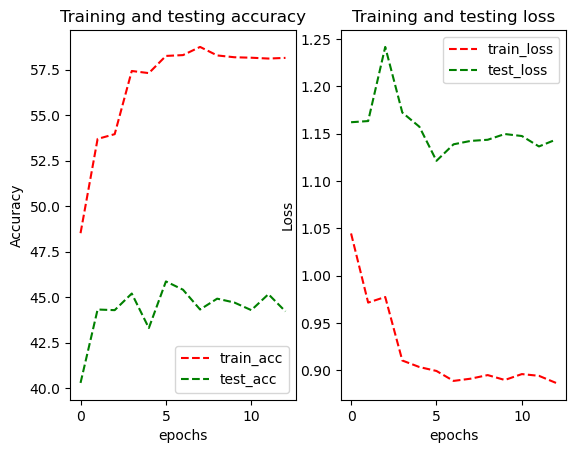

Testing Accuracy: 40.0000%, Testing Loss: 1.23935078


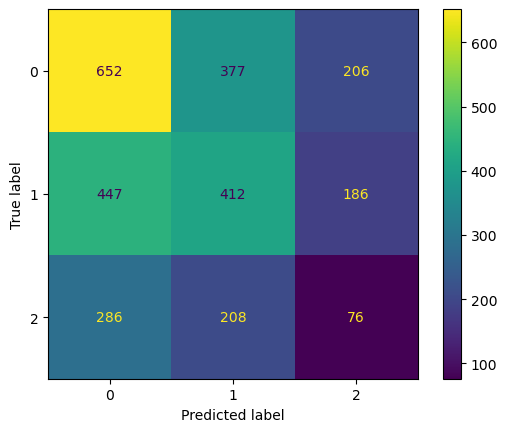

In [9]:
EPOCHS = 13
LEARNING_RATE = 4e-3
BATCH_SIZE = 36
resampled_dataset = resampling(train_dataset.images, train_dataset.labels, 'SMOTE')
model = Model(train_dataset=resampled_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='ViT', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=3)
model.start()

# Data augmentation test

## EffNet trail

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 0
Training Accuracy: 50.4924%, Training Loss: 0.97203740
Validation Accuracy: 46.4211%, Validation Loss: 1.09241166


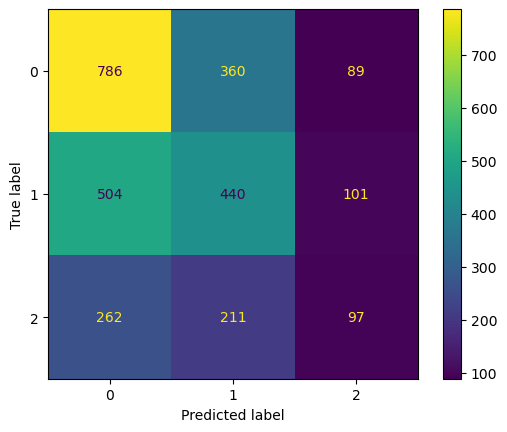

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 1
Training Accuracy: 69.2473%, Training Loss: 0.69409148
Validation Accuracy: 48.8421%, Validation Loss: 1.23546716


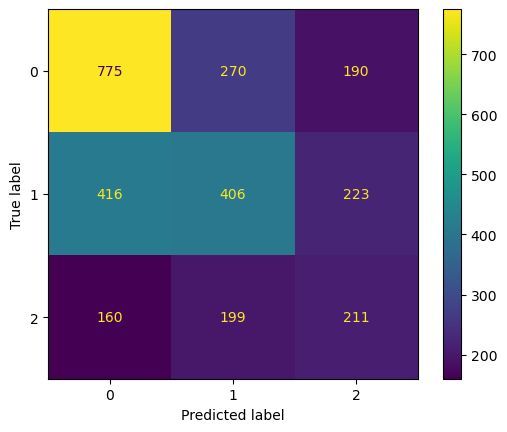

Adjusting learning rate of group 0 to 3.0000e-04.
epoch: 2
Training Accuracy: 82.0260%, Training Loss: 0.44619236
Validation Accuracy: 54.2105%, Validation Loss: 1.41716484


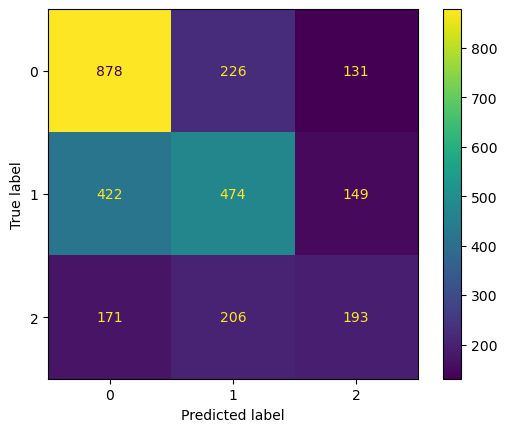

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 3
Training Accuracy: 86.7799%, Training Loss: 0.33303642
Validation Accuracy: 54.4561%, Validation Loss: 1.36305065


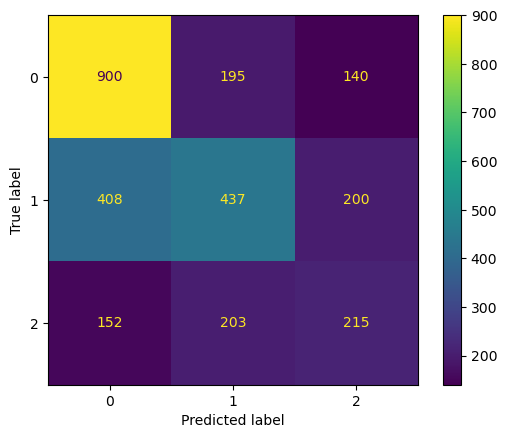

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 4
Training Accuracy: 88.9078%, Training Loss: 0.29219313
Validation Accuracy: 55.7193%, Validation Loss: 1.42220081


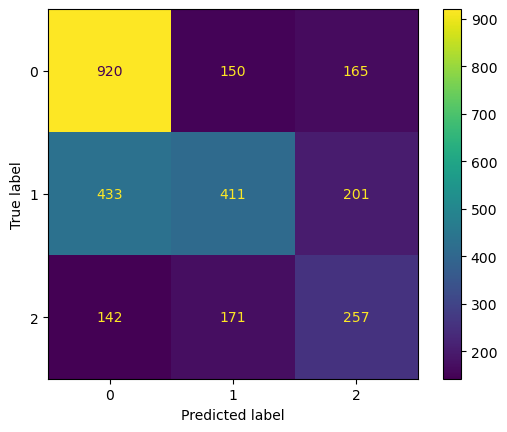

Adjusting learning rate of group 0 to 3.0000e-05.
epoch: 5
Training Accuracy: 89.6321%, Training Loss: 0.27478941
Validation Accuracy: 55.4035%, Validation Loss: 1.43138757
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 6
Training Accuracy: 89.7453%, Training Loss: 0.26962703
Validation Accuracy: 56.3158%, Validation Loss: 1.43384415


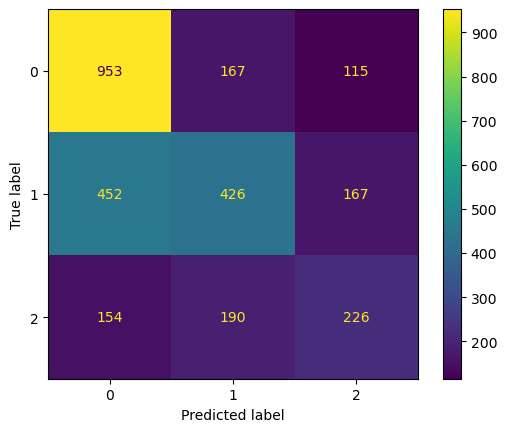

Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 7
Training Accuracy: 89.7680%, Training Loss: 0.27148053
Validation Accuracy: 55.3684%, Validation Loss: 1.39623857
Adjusting learning rate of group 0 to 3.0000e-06.
epoch: 8
Training Accuracy: 89.9151%, Training Loss: 0.26609323
Validation Accuracy: 53.8246%, Validation Loss: 1.39893049
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 9
Training Accuracy: 90.0396%, Training Loss: 0.26466194
Validation Accuracy: 55.2281%, Validation Loss: 1.37574182
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 10
Training Accuracy: 90.1415%, Training Loss: 0.26303910
Validation Accuracy: 54.2807%, Validation Loss: 1.38887525
Adjusting learning rate of group 0 to 3.0000e-07.
epoch: 11
Training Accuracy: 90.2886%, Training Loss: 0.26052055
Validation Accuracy: 54.6667%, Validation Loss: 1.45019738
Adjusting learning rate of group 0 to 3.0000e-08.
epoch: 12
Training Accuracy: 89.8132%, Training Loss: 0.26908117
Validation Accurac

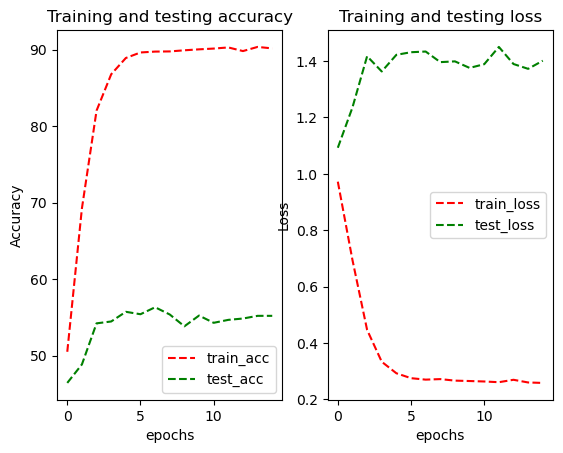

Testing Accuracy: 62.0702%, Testing Loss: 1.17909305


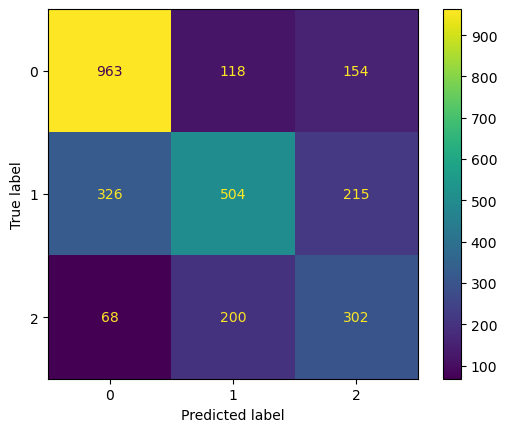

In [10]:
EPOCHS = 15
LEARNING_RATE = 0.0003
BATCH_SIZE = 48
model = Model(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='effinet', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=3)
model.start()

# ViT trail

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 0
Training Accuracy: 48.6248%, Training Loss: 1.02788169
Validation Accuracy: 46.7018%, Validation Loss: 1.09256272


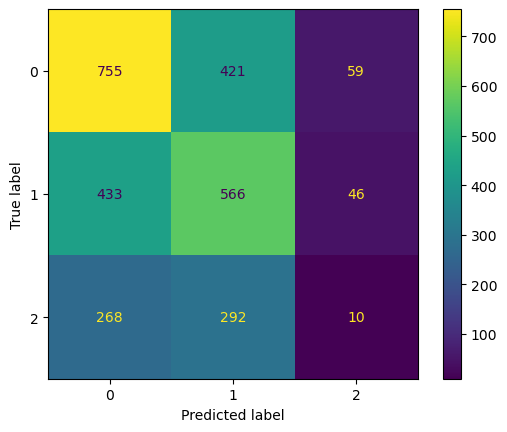

Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 1
Training Accuracy: 53.6842%, Training Loss: 0.95573848
Validation Accuracy: 45.1228%, Validation Loss: 1.32492575
Adjusting learning rate of group 0 to 4.0000e-03.
epoch: 2
Training Accuracy: 55.9932%, Training Loss: 0.93811375
Validation Accuracy: 44.5965%, Validation Loss: 1.16336951
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 3
Training Accuracy: 58.5059%, Training Loss: 0.88868031
Validation Accuracy: 43.8246%, Validation Loss: 1.08752792
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 4
Training Accuracy: 59.6378%, Training Loss: 0.86698114
Validation Accuracy: 44.0702%, Validation Loss: 1.09056927
Adjusting learning rate of group 0 to 4.0000e-04.
epoch: 5
Training Accuracy: 59.2643%, Training Loss: 0.87332018
Validation Accuracy: 45.1228%, Validation Loss: 1.09714380
Adjusting learning rate of group 0 to 4.0000e-05.
epoch: 6
Training Accuracy: 60.3622%, Training Loss: 0.85674885
Validation Accuracy: 

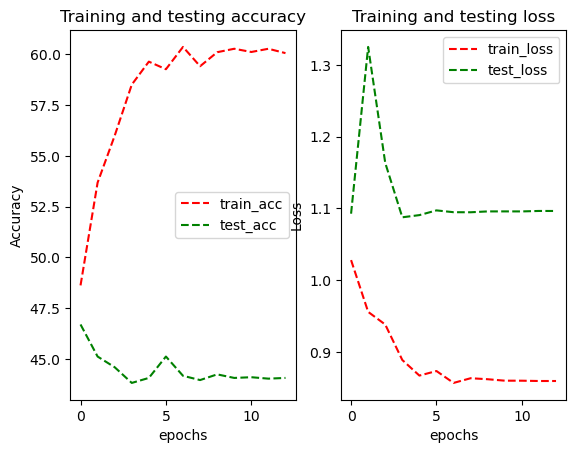

Testing Accuracy: 44.8772%, Testing Loss: 1.09868620


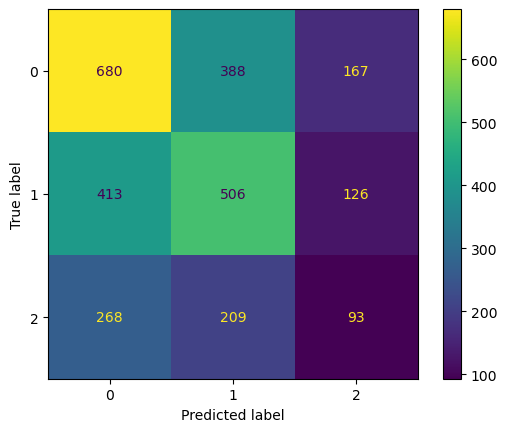

In [9]:
EPOCHS = 13
LEARNING_RATE = 4e-3
BATCH_SIZE = 48
# resampled_dataset = resampling(train_dataset.images, train_dataset.labels, 'SMOTEENN')
model = Model(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_type='ViT', epoch=EPOCHS, lr=LEARNING_RATE, schedular=True, bs=BATCH_SIZE, stepSize=3)
model.start()